<img src="images/buildacourt.jpg" alt="Drawing" style="width: 438px;"/><img src="images/luxurycourt.jpg" alt="Drawing" style="width: 492px;"/>

## Step 4 - Building a Model - ATP Match Statistics

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
dflog = pd.read_csv('data/results.csv')
dflog = dflog.drop(['Unnamed: 0'], axis = 1)
dflogtrain = pd.read_csv('data/test.csv')
dflogtrain = dflogtrain.drop(['Unnamed: 0'], axis = 1)
dflogtest = pd.read_csv('data/test.csv')
dflogtest = dflogtest.drop(['Unnamed: 0'], axis = 1)

In [3]:
dflog.head()

,match_id,match_duration,rank_dif,date,year,month,day,aces,double_faults,first_serves_in,first_serves_total,first_serve_points_won,first_serve_points_total,second_serve_points_won,second_serve_points_total,break_points_saved,break_points_serve_total,service_points_won,service_points_total,first_serve_return_won,first_serve_return_total,second_serve_return_won,second_serve_return_total,break_points_converted,break_points_return_total,service_games_played,return_games_played,return_points_won,return_points_total,total_points_won,total_points_total,player_id,match_score_tiebreaks,sets_won,games_won,tiebreaks_won,rank_number,ranking_points,ace_pct,df_pct,srv_pts_pct,rtn_pts_pct,brk_pts_pct,points_won_pct,win
0,1991-354-a028-c113,66.0,51.0,1990-12-31,1990,12,31,2.0,1.0,29.0,48.0,26.0,29.0,12.0,19.0,0.0,0.0,38.0,48.0,15.0,42.0,8.0,14.0,3.0,12.0,9.0,9.0,23.0,56.0,61.0,104.0,a028,62 64,2,12,0,64.0,0.0,4.166667,2.083333,79.166667,41.071429,25.000000,58.653846,1
1,1991-354-a028-c113,66.0,-51.0,1990-12-31,1990,12,31,3.0,3.0,42.0,56.0,27.0,42.0,6.0,14.0,9.0,12.0,33.0,56.0,3.0,29.0,7.0,19.0,0.0,0.0,9.0,9.0,10.0,48.0,43.0,104.0,c113,62 64,0,6,0,115.0,0.0,5.357143,5.357143,58.928571,20.833333,0.000000,41.346154,0
2,1991-354-b040-c260,147.0,-59.0,1990-12-31,1990,12,31,3.0,2.0,56.0,94.0,37.0,56.0,21.0,38.0,3.0,6.0,58.0,94.0,30.0,72.0,12.0,34.0,3.0,15.0,12.0,12.0,42.0,106.0,100.0,200.0,b040,76(5) 76(8),2,14,2,80.0,0.0,3.191489,2.127660,61.702128,39.622642,20.000000,50.000000,1
3,1991-354-b040-c260,147.0,59.0,1990-12-31,1990,12,31,4.0,1.0,72.0,106.0,42.0,72.0,22.0,34.0,12.0,15.0,64.0,106.0,19.0,56.0,17.0,38.0,3.0,6.0,12.0,12.0,36.0,94.0,100.0,200.0,c260,76(5) 76(8),0,12,0,21.0,0.0,3.773585,0.943396,60.377358,38.297872,50.000000,50.000000,0
4,1991-354-b040-m048,68.0,40.0,1990-12-31,1990,12,31,2.0,1.0,37.0,49.0,25.0,37.0,6.0,12.0,4.0,6.0,31.0,49.0,24.0,47.0,6.0,8.0,6.0,11.0,8.0,9.0,30.0,55.0,61.0,104.0,b040,63 62,2,12,0,80.0,0.0,4.081633,2.040816,63.265306,54.545455,54.545455,58.653846,1


In [4]:
features = ['aces','ace_pct','double_faults','df_pct','first_serves_in','srv_pts_pct','first_serve_points_won',
            'return_points_won','rtn_pts_pct','break_points_converted','brk_pts_pct','total_points_won','points_won_pct']
features1 = ['rank_dif','aces','double_faults','first_serves_in', 'first_serve_points_won','second_serve_points_won',
            'break_points_saved','service_points_won','first_serve_return_won','second_serve_return_won',
            'break_points_converted','service_games_played','return_games_played','return_points_won',
            'total_points_won','games_won','ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']
predictor = ['win']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['aces','ace_pct','double_faults','df_pct','first_serves_in','srv_pts_pct','first_serve_points_won',
            'return_points_won','rtn_pts_pct','break_points_converted','brk_pts_pct','total_points_won','points_won_pct']].values, 
                                              (dflog.win == 1).values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9514536665077961


In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [7]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9507274104191481


In [8]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
scr=[]

for value in Cs:
    #Creating Logistic Regression object with different C values from above list.
    clf1 = LogisticRegression(C=value)
    # Fit the model on the trainng data.
    clf1.fit(Xlr, ylr)
    score = cv_score(clf1, Xlr, ylr)
    #print("C value: " + str(value) + " LogisticRegression Score: " + str(score))
    scr.append(score)

#average score for this model using the cv_score function only on the training set (Xlr, ylr) 
avg = np.mean(scr)
print("Average Score for this model is: " + str(avg))

#picking the C with the highest average score

diff=(avg-scr)
df = pd.DataFrame(np.column_stack([Cs, scr, diff]), columns=['Cval', 'Score', 'diff'])
#df.max()

# So C value is 0.001 for highest average score.

Average Score for this model is: 0.9364335894983608


In [9]:
# Logistic Regression on the test data using C value from training data
#Creating Logistic Regression object with different C values from above list.
clf2 = LogisticRegression(C=0.001)
# Fit the model on the trainng data.
clf1.fit(Xlr, ylr)
score = cv_score(clf2, Xtestlr, ytestlr)
score

0.8814598131891469

In [10]:
from sklearn.model_selection import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

(LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 {'C': 100},
 0.9516201024337472,
 {'mean_fit_time': array([0.70859528, 0.92814975, 3.16363297, 3.91326418, 3.96339998,
         3.99690366]),
  'std_fit_time': array([0.04754539, 0.01689939, 0.34789144, 0.24954856, 0.33262758,
         0.26405843]),
  'mean_score_time': array([0.00378447, 0.00276432, 0.00279317, 0.00319848, 0.00299211,
         0.00258684]),
  'std_score_time': array([0.00041251, 0.00073926, 0.00074651, 0.00039595, 0.00063083,
         0.00049621]),
  'param_C': masked_array(data=[0.0001, 0.001, 0.1, 1, 10, 100],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{

In [11]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.9521799323664919

In [12]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [13]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [15]:
dflog.head()

,match_id,match_duration,rank_dif,date,year,month,day,aces,double_faults,first_serves_in,first_serves_total,first_serve_points_won,first_serve_points_total,second_serve_points_won,second_serve_points_total,break_points_saved,break_points_serve_total,service_points_won,service_points_total,first_serve_return_won,first_serve_return_total,second_serve_return_won,second_serve_return_total,break_points_converted,break_points_return_total,service_games_played,return_games_played,return_points_won,return_points_total,total_points_won,total_points_total,player_id,match_score_tiebreaks,sets_won,games_won,tiebreaks_won,rank_number,ranking_points,ace_pct,df_pct,srv_pts_pct,rtn_pts_pct,brk_pts_pct,points_won_pct,win
0,1991-354-a028-c113,66.0,51.0,1990-12-31,1990,12,31,2.0,1.0,29.0,48.0,26.0,29.0,12.0,19.0,0.0,0.0,38.0,48.0,15.0,42.0,8.0,14.0,3.0,12.0,9.0,9.0,23.0,56.0,61.0,104.0,a028,62 64,2,12,0,64.0,0.0,4.166667,2.083333,79.166667,41.071429,25.000000,58.653846,1
1,1991-354-a028-c113,66.0,-51.0,1990-12-31,1990,12,31,3.0,3.0,42.0,56.0,27.0,42.0,6.0,14.0,9.0,12.0,33.0,56.0,3.0,29.0,7.0,19.0,0.0,0.0,9.0,9.0,10.0,48.0,43.0,104.0,c113,62 64,0,6,0,115.0,0.0,5.357143,5.357143,58.928571,20.833333,0.000000,41.346154,0
2,1991-354-b040-c260,147.0,-59.0,1990-12-31,1990,12,31,3.0,2.0,56.0,94.0,37.0,56.0,21.0,38.0,3.0,6.0,58.0,94.0,30.0,72.0,12.0,34.0,3.0,15.0,12.0,12.0,42.0,106.0,100.0,200.0,b040,76(5) 76(8),2,14,2,80.0,0.0,3.191489,2.127660,61.702128,39.622642,20.000000,50.000000,1
3,1991-354-b040-c260,147.0,59.0,1990-12-31,1990,12,31,4.0,1.0,72.0,106.0,42.0,72.0,22.0,34.0,12.0,15.0,64.0,106.0,19.0,56.0,17.0,38.0,3.0,6.0,12.0,12.0,36.0,94.0,100.0,200.0,c260,76(5) 76(8),0,12,0,21.0,0.0,3.773585,0.943396,60.377358,38.297872,50.000000,50.000000,0
4,1991-354-b040-m048,68.0,40.0,1990-12-31,1990,12,31,2.0,1.0,37.0,49.0,25.0,37.0,6.0,12.0,4.0,6.0,31.0,49.0,24.0,47.0,6.0,8.0,6.0,11.0,8.0,9.0,30.0,55.0,61.0,104.0,b040,63 62,2,12,0,80.0,0.0,4.081633,2.040816,63.265306,54.545455,54.545455,58.653846,1


In [16]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['aces','ace_pct','double_faults','df_pct','first_serves_in','srv_pts_pct','first_serve_points_won',
            'return_points_won','rtn_pts_pct','break_points_converted','brk_pts_pct','total_points_won','points_won_pct'], 'win',1)

BEST PARAMS {'C': 10}
Accuracy on training data: 0.95
Accuracy on test data:     0.95


ValueError: X has 2 features per sample; expecting 13

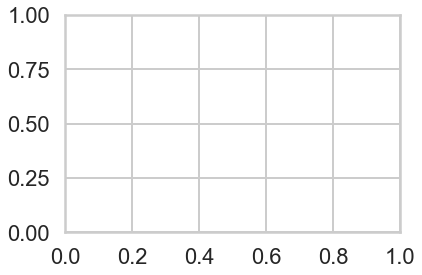

In [17]:
'''plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);'''

In [18]:
clf_l.predict_proba(Xtest_l)

array([[9.23057585e-03, 9.90769424e-01],
       [9.32992525e-01, 6.70074749e-02],
       [1.23118673e-01, 8.76881327e-01],
       ...,
       [3.47065461e-01, 6.52934539e-01],
       [9.99922584e-01, 7.74157488e-05],
       [4.91182710e-03, 9.95088173e-01]])

ValueError: X has 2 features per sample; expecting 13

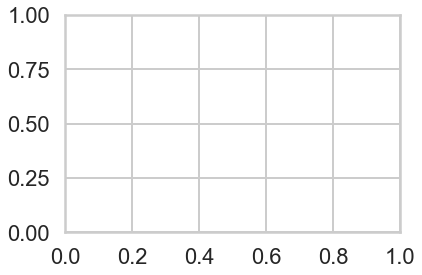

In [19]:
plt.figure()
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);